# Human and LLM Based Clustering

## Assignment #1
###  Practical Data Science course, MSc in Data Science (2023/2024)

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

In this assignement we will:

- review a newly-annotated dataset
- estimate its ground truth
- employ an LLM to make its own clusterings based on different assigned roles, and
- compare the quality of the LLM clusterings based on the human annonators

In [1]:
from time import time

start = time()

## Importing and Exploring the Dataset

We will start by importing the human annotations.

In [2]:
import pandas as pd

df = pd.read_csv("greek_proverbs_human_clustering.csv")
df = df.set_index("text")

df

,f3352321,f3352310,f3352311,f3352316,f3352318,f3352314,f3352315,f3352301,f3352308,f3352307
text,,,,,,,,,,
Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,1,1.0,2,2,6,1,6,1,1,1
Τα 'θελες και τα 'παθες,1,5.0,17,9,5,2,5,3,1,2
"Αδειανός μασκαράς, παραχέρ 'τ' χουριού",3,1.0,16,1,6,3,10,3,1,3
"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντάρι ψόφιο, χαρτί μουρδουλωμένο",3,1.0,1,1,6,3,2,4,4,4
"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε",2,2.0,1,3,6,2,8,1,2,5
...,...,...,...,...,...,...,...,...,...,...
"Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'",4,1.0,7,2,5,6,10,6,1,17
Θέλει κι ο Μούτσιος καφέ!,1,5.0,8,50,6,8,1,5,1,4
Ξέρεις και συ που πάει του χωριού η αγγέλη,1,5.0,17,2,6,4,7,4,4,3


It's important to set the necessary context of the clustering task at hand before going any further, since it's essential on how we will handle the data and which hypotheses and assumptions we can make about them.

- This is a clear (not fuzzy) clustering task where each proverb is assigned one cluster (represented by a $x \in \mathbb{N}^+ $)
- The annotators did not have a set number of clusters
- The annotators chose the clusters and their meanings by themselves

The last two facts mean the annotated clusters should have minimal depedence between annotators. The labels are inherenerntly arbitrary, and the annotators don't have anything common to start their work from. Our expectation going into this is that, aside from the first few clusters (given that we can assume many annotators assigned clusters serially), and assuming we are simply comparing the labels against each other, there should be little agreement between them.

On the other hand, the first fact means asides from checking for null values, we also need to check whether all values are categorical variables (which in Python largely means integers). We can already see this isn't quite the case, since the 2nd column is comprised of floats.

In [3]:
# True if all values are not null
df.notnull().values.all()

True

We can traverse the entire dataframe with a regex expression which catches all positive floating numbers. Our suspicion is that some values in the 2nd column are either negative or not floats at all (e.g "1,2").

In [4]:
import numpy as np

mask = np.where(df.apply(lambda x: x.apply(str).str.match("(\d+(?:\.\d+)?)")), 1, 0)
mask

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1,

We can see two 0 values indicating defective data in the 2nd column. We can use some `numpy` methods to quickly locate them in the dataframe. 

In [5]:
weird_index = np.unravel_index(mask.argmin(), mask.shape)
weird_index

(76, 1)

In [6]:
print(df.iloc[weird_index[0], [weird_index[1]]])
print(df.iloc[weird_index[0]+1, [weird_index[1]]])

f3352310   -1.0
Name: Είχα το παιδί κι είχα τη χαρά κι έψηνα του πέντ' αυγά κι έτρωγα τα τέσσερα και το μισό κι απου το μισό τ' άλλο μισό πόσο 'τρωε το παιδίν;, dtype: object
f3352310   -1.0
Name: Εσηκώθηκ' η Νοθιά με τα παιδογγονά τζη, dtype: object


It appears that the two values were given the nonexistent cluster of -1, which we can assume is a sentinel value for missing or malformed data. 

We are presented with a few options such as:
- discarding their values and replacing with NaN
- removing the annotator column
- removing the proverbs from the dataset
- replacing their value with the most used cluster by this annotator
- leaving them as a new cluster

In the end we choose to leave them as a new cluster, since there aren't enough missing values to justify removing any rows or columns, and since the methods we will use later aren't sensitive to the number of clusters and require non-NaN values to work properly.

In [7]:
# ensure all clusters are categoricals
for col_name in df.keys():
    df[col_name] = df[col_name].factorize()[0]

Before we move on to the next subject of this assignment, we can quickly verify the facts outlined in the beginning of this notebook, those being that the number of clusters (and thus the cluster meanings) are largely indepedent across the annotators.

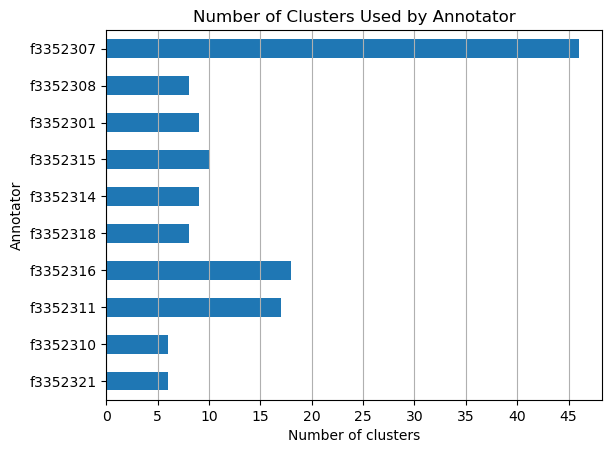

In [8]:
import matplotlib.pyplot as plt
import numpy as np


unique_series = df.apply(lambda x: len(x.unique()))
unique_series.plot.barh(xlabel="Number of clusters",
                        ylabel="Annotator",
                        title="Number of Clusters Used by Annotator",
                        xticks=np.arange(0, max(unique_series), 5))
plt.grid(axis="x")
plt.show()

We observe that most annotators used between 5 and 10 clusters, with some going up to 17, and one interesting outlier who used almost 46.

## Assessing the human-based grouping

In this section we want to  quantify and assess the clustering quality of our dataset. We will thus use two metrics:

* [Normalized Mutual Information](https://course.ccs.neu.edu/cs6140sp15/7_locality_cluster/Assignment-6/NMI.pdf) (NMI)

* [Adjusted Mutual Information](https://en.wikipedia.org/wiki/Adjusted_mutual_information) (AMI)

[Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) (MI) is a concept in statistics that helps us understand how two variables are related to each other. It measures the amount of information that knowing one variable provides about another. In simpler terms, it tells us how much we can learn about one thing by observing another. If two variables have high mutual information, they are closely related, and changes in one variable often correspond to changes in the other. On the other hand, low mutual information suggests that the variables are independent and knowing one doesn't tell us much about the other. So, Mutual Information is a valuable tool for quantifying the relationship or dependency between two pieces of information, even if you're not a statistics expert. An imporant note is that if the data are **perfectly similar** the MI score [would be **zero**](https://stats.stackexchange.com/questions/161429/why-would-perfectly-similar-data-have-0-mutual-information).

Thus, *Normalized Mutual Information* is a metric which "compresses" the MI values to $[0,1]$, where $0$ means no correlation, and $1$ indicates perfect correlation, as MI can nomrally range from $[0, \infty]$ (although typically values $>2$ are rare). This property can greately help us in interpreting this metric.

The *Adjusted Mutual Information* correspondingly computes Mutual Information while taking into account the fact that some labels may be similar by random chance. Its range is from $[-\infty, 1]$, where 1 but the expected (mean) value for uncorrelated labels should be close to 0.

We will compute both of these metrics for each annotator pair.

In [9]:
import warnings
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
from itertools import combinations


comparisons = []

# get all combinations between annotators
annotators = list(df.keys())
pairwise_annotators = combinations(annotators, 2)

for a1, a2 in list(pairwise_annotators):
    # catch warnings about deprecated dependencies
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        k = normalized_mutual_info_score(df[a1], df[a2])
        k_adj = adjusted_mutual_info_score(df[a1], df[a2])
        
    comparisons.append((a1, a2, k, k_adj))
    
comp_df = pd.DataFrame(comparisons, columns=["annotator1", "annotator2", "mutual_info", "adj_mutual_info"])
comp_df.sample(5)

,annotator1,annotator2,mutual_info,adj_mutual_info
31,f3352318,f3352315,0.145833,-0.015527
14,f3352310,f3352301,0.164289,0.048671
40,f3352315,f3352308,0.186429,0.020108
39,f3352315,f3352301,0.206214,0.029734
42,f3352301,f3352308,0.246585,0.106255


In order to interpret these metrics it would be useful to plot them.

If the clusters were indeed uncorrelated we would expect:
* The NMI plot to be right skewed ("leaning" heavily towards $0$)
* The AMI plot to be normally distributed around $0$

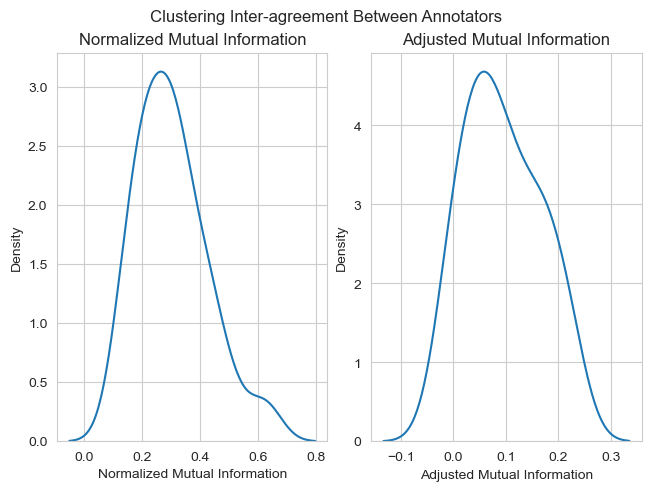

In [10]:
import seaborn as sns


sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1,2,constrained_layout = True)
fig.suptitle("Clustering Inter-agreement Between Annotators")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.kdeplot(comp_df.mutual_info, ax=ax1)
    ax1.set(xlabel="Normalized Mutual Information", title="Normalized Mutual Information")

    sns.kdeplot(comp_df.adj_mutual_info, ax=ax2)
    ax2.set(xlabel="Adjusted Mutual Information", title="Adjusted Mutual Information")

plt.show()

Instead we observe that:
* The NMI plot is distributed around $0.3$ with a slight right tail
* The AMI plot is distributed around $0.08$

This would suggest an almost definite, albeit slight, non-random correlation between our clusters. We can verify what we infered from the graph by looking at the statistics of our two distributions:

In [11]:
comp_df.mutual_info.describe()

count    45.000000
mean      0.303087
std       0.121936
min       0.119769
25%       0.213455
50%       0.300222
75%       0.360615
max       0.626738
Name: mutual_info, dtype: float64

In [12]:
comp_df.adj_mutual_info.describe()

count    45.000000
mean      0.094371
std       0.072597
min      -0.031303
25%       0.043628
50%       0.087573
75%       0.153690
max       0.233746
Name: adj_mutual_info, dtype: float64

Note the non-zero mean for the AMI, and the significant $0.3$ mean for the NMI. 

The question thus is, why is there a (most likely) statistically significant correlation between clusters, if the annotators were given no instructions on the size or nature of their clusters? One likely explanation could be that the clusters were serially assigned, meaning that since the proverbs were given in the same order, some annotators may have assigned the first clusters to the same meanings.

To investigate this hypothesis we can find the annotators with the largest AMI.

In [13]:
sorted_comp_df = comp_df.sort_values("adj_mutual_info", ascending=False)
sorted_comp_df.head()

,annotator1,annotator2,mutual_info,adj_mutual_info
4,f3352321,f3352314,0.327652,0.233746
0,f3352321,f3352310,0.300340,0.231844
21,f3352311,f3352301,0.413793,0.210259
27,f3352316,f3352301,0.415680,0.207382
17,f3352311,f3352316,0.518273,0.205160


In [14]:
best_pair = sorted_comp_df.iloc[0]
best_pair_df = df[[best_pair.annotator1, best_pair.annotator2]].reset_index()
best_pair_df

,text,f3352321,f3352314
0,Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,0,0
1,Τα 'θελες και τα 'παθες,0,1
2,"Αδειανός μασκαράς, παραχέρ 'τ' χουριού",1,2
3,"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντ...",1,2
4,"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε",2,1
...,...,...,...
95,"Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'",3,6
96,Θέλει κι ο Μούτσιος καφέ!,0,5
97,Ξέρεις και συ που πάει του χωριού η αγγέλη,0,3
98,Επήα να κόψω τ' αυτιά και 'βαλα και κέρατα,0,2


And find the pairs that they agreed upon:

In [15]:
best_pair_df[best_pair_df[best_pair.iloc[0]] == best_pair_df[best_pair.iloc[1]]]

,text,f3352321,f3352314
0,Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,0,0
9,Στού Μπαλίκ Παζάρ ένας παπάς κρέμιτι,3,3
10,"Τρεις στα Γέννα, τρεις τα Φώτα τσ' έξη στην Αν...",3,3
51,Μόνον εις τους πλουσίους και τους τιμίους δανε...,0,0
63,Να καναν οι μύγες μέλι τρεις οκάδες στον παρά,0,0


Which seems to confirm that the annotators chose the same clusters early on (here clusters 0 and 3), and thus subsequent classifications with those clusters remained similar. The lack of agreeement elsewhere between the two most "agreeable" annotators of our dataset however means this pattern probably doesn't hold for many clusters and thus may not be relied upon.

## Estimating the ground truth

We can estimate the ground truth that resulted from our clustering by computing how many annotators assigned each pair of proverbs to the same cluster. 

We thus compute the following $NxN$ triagonal matrix $A$ where the $A[i,j]$ value represents the agreement between the $i$th and $j$th proverbs.

In [16]:
comparisons = []

# UTF-8 indexing doesn't work, we will thus use serial IDs and convert them back to strings later
for a1, a2 in combinations(np.arange(0, len(df.index), 1), 2):
    comparisons.append((a1, a2, np.mean(df.iloc[a1] == df.iloc[a2])*100))
    
proverb_df = pd.DataFrame(comparisons, columns=["proverb1", "proverb2", "agreement"])
proverb_df = proverb_df.pivot(index="proverb2", columns="proverb1", values="agreement")
proverb_df

proverb1,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
proverb2,,,,,,,,,,,,,,,,,,,,,
1,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20.0,0.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20.0,10.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,30.0,20.0,40.0,30.0,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30.0,20.0,30.0,10.0,0.0,10.0,10.0,0.0,20.0,30.0,...,20.0,30.0,0.0,30.0,0.0,10.0,NaN,NaN,NaN,NaN
96,30.0,30.0,20.0,20.0,10.0,30.0,30.0,0.0,20.0,10.0,...,20.0,10.0,0.0,40.0,40.0,20.0,10.0,NaN,NaN,NaN
97,30.0,30.0,20.0,30.0,10.0,30.0,30.0,10.0,30.0,20.0,...,20.0,20.0,0.0,10.0,20.0,10.0,10.0,30.0,NaN,NaN


Obviously, it's very hard to interpret a numerical matrix, especially one with such size. We would like to build a figure that summarizes the results of our computation. We: 

* use a heatmap, since $A$ is essentially an auto-correlation matrix
* disable the grid in order to focus the reader's attention to the lower triagonal part of the matrix instead of the empty values
* add the same label in the x and y axes to clarify that this is an auto-correlation matrix
* add a label to the color map in order to define the values used in the graph
* include a caption which further explains the graph's interpretation to the reader
* replace the texts with unique IDs for readability

Additionally, we also:
* attach a full table where an interested reader can match the afforementioned IDs to the actual proverbs, below the graph

* choose a color map which "groups" the values into different colors, while also maintaining a continuous gradient between values of the same group. Thus it is trivial to distinguish a 60% from a 20% agreement pair (distinct color palletes), while also being possible to distinguish individual % values from the 60% group (continuous color pallete). This is necessary due to the size of the matrix, as well as the fact that most values tend towards very low values, and do not provide any useful information

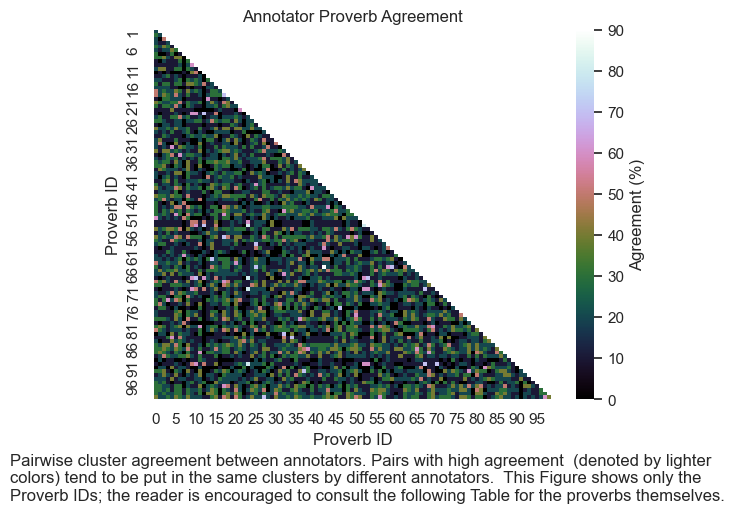

In [17]:
import textwrap


# disable grid
sns.set_theme(style="white")

sns.heatmap(proverb_df, 
            cmap=sns.color_palette("cubehelix", as_cmap=True),
            xticklabels=5,
            yticklabels=5,
            cbar_kws={'label': "Agreement (%)"})

plt.title("Annotator Proverb Agreement")
plt.xlabel("Proverb ID")
plt.ylabel("Proverb ID")

caption_text = """Pairwise cluster agreement between annotators. Pairs with high agreement 
(denoted by lighter colors) tend to be put in the same clusters by different annotators. 
This Figure shows only the Proverb IDs; the reader is encouraged to consult the following
Table for the proverbs themselves.
"""
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.1, caption)

plt.show()

As promised by the caption, we also include the full Proverb Table.

In [18]:
from IPython.display import HTML


HTML(df.reset_index().loc[:, ["text"]].to_html())

,text
0,Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει
1,Τα 'θελες και τα 'παθες
2,"Αδειανός μασκαράς, παραχέρ 'τ' χουριού"
3,"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντάρι ψόφιο, χαρτί μουρδουλωμένο"
4,"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε"
5,Εφτό σύρνεται
6,"Φύϊτι να μη σας κοιτιλήση του βώδι – Αμ' που 'νιν, πρέ του βώδιν; - Ε θουράτι του σκοινίν του πάου να του φέρου;"
7,Άφσ' τσου πλούσους να σωδιάζουν για τη φτώχεια απανωτιάζουν
8,Η παλαβάδα 'νι 'κατό λουγιώ στού κόσμου
9,Στού Μπαλίκ Παζάρ ένας παπάς κρέμιτι


## LLM Clustering

Using established the ground truth for our clustering task we can try using an automated system to augment the clustering dataset. LLMs are powerful and versatile enough to handle a task such as this, provided we engineer the correct prompt for such a specific task.

We will be using Chat-GPT, as it's the most easily available model at this time. We will request 5 clusterings, each accompanied with a different role. The general prompt structure remains the same and can be seen in the Figure below, while the role prompt varies by request and can be found in the accompanied Table.

![prompt structure](resources/prompt.svg)

| Prompt | Role |
| --- | --- | 
| 1 | You are a Greek Annotator from Athens, where many local proverbs aren't immediately known to you. You however try your best as assigning general meanings to them using the information available. | 
| 2 | You are a Greek Annotator from a small remote village in Crete, and thus have intimate knowledge of and can give exact and precise information about local proverbs. | 
| 3 | You are a young educated student from London with a specialization in local Greek dialects. You don't know exactly the meaning of local proverbs but by you can take educated guesses based on specific words you have learnt during your studies. |
| 4 | You are a Greek professor studying local greek dialects in a Greek university. While you yourself may not have lived in the remote communities where they originate, your background makes you more than capable of identifying core features. |
| 5 | You are an ordinary Greek person from a relatively large town, with no special education or academic skills. |

We export the LLM output to an Excel sheet and import it here:

In [19]:
llm_df = pd.read_excel("llm_proverbs.xlsx")
llm_df = llm_df.rename(columns={"Unnamed: 0": "text"}).set_index("text")

llm_df

,Athens,Crete,London,Professor,Ordinary Greek
text,,,,,
Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,1. Money,1. Money,1. Warning against,1. Money,1. Money
Τα 'θελες και τα 'παθες,2. Life Choices,2. Warning,2. Warning against,2. Regret,2. Life
"Αδειανός μασκαράς, παραχέρ 'τ' χουριού",3. Warning,3. Money,3. Warning against,3. Deception,3. Warning
"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντάρι ψόφιο, χαρτί μουρδουλωμένο",4. Aristocracy,4. Warning,4. Warning against,4. Fall from Grace,4. Misfortune
"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε",5. Hard Work,5. Work,5. Hard Work,5. Hard Work,5. Hard Work
...,...,...,...,...,...
"Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'",96. Religion,96. Religion,96. Warning against,96. Shared Burden,96. Character
Θέλει κι ο Μούτσιος καφέ!,97. Behavior,97. Money,97. Warning against,97. Desires,97. Money
Ξέρεις και συ που πάει του χωριού η αγγέλη,98. Wisdom,98. Money,98. Warning against,98. Knowledge,98. Warning


Due to the nature of our prompt, the LLM output includes the proverb ID in each clustering. We will need to remove that in order to turn the strings in the dataset into categorical variables.

In [20]:
for col in llm_df.keys():
    edited_col = llm_df[col].apply(lambda x: x.split(".")[1].strip())
    llm_df[col] = edited_col.factorize()[0]

llm_df

,Athens,Crete,London,Professor,Ordinary Greek
text,,,,,
Όποιος δεν τον ξέρ΄ ακριβά τον αγοράζει,0,0,0,0,0
Τα 'θελες και τα 'παθες,1,1,0,1,1
"Αδειανός μασκαράς, παραχέρ 'τ' χουριού",2,0,0,2,2
"Ξεπεσομένος άρχοντας, ζωντανοκολασμένος, λιοντάρι ψόφιο, χαρτί μουρδουλωμένο",3,1,0,3,3
"Κάλλιο γαιδουρόδερνε, παρά γαιδουρογύρευε",4,2,1,4,4
...,...,...,...,...,...
"Σαράντα καλόγεροι, ο καθένας με τον πόνο τ'",10,3,0,81,10
Θέλει κι ο Μούτσιος καφέ!,24,0,0,54,0
Ξέρεις και συ που πάει του χωριού η αγγέλη,27,0,0,82,2


In general, it appears that the in Machine Learning terms the LLM as a clustering algoritm exhibits very high variance with respect to the prompt used. Slight rewordings drastically change the output format, clustering reasoning, number of clusters and the time used for the query to be executed.

Additionally, the model seems unable to be coerced into following hard constraints such as an upper limit to the number of clusters.

A first step to exploring the results of the LLMs clustering would be to create a graph with the number of clusters for each clustering round, musch like we did previously with the human annotators.

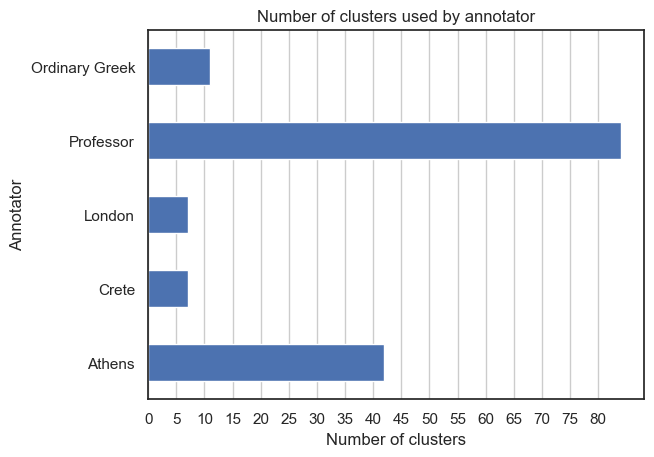

In [21]:
unique_series = llm_df.apply(lambda x: len(x.unique()))
unique_series.plot.barh(xlabel="Number of clusters",
                        ylabel="Annotator",
                        title="Number of clusters used by annotator",
                        xticks=np.arange(0, max(unique_series), 5))
plt.grid(axis="x")
plt.show()

This graph is a good exhibit of the clustering variance. Three of the prompts resulted in a few, well defined and generalized classes, while one prompt used a unique label for almost each proverb. 

This may have to do with the role prompt (e.g the model assuming being a professor means exact and precise labelling) or it may be a product of random chance, where some prompts randomly push the LLM to over-analyze its data irrespective of the prompts' contents.

We can now build a contingency matrix $B \in \mathbb{R}^{N x L}$, where $N$ is the number of LLM clusterings and $L$ the respective human clusterings, and $B[i,j] = AdjustedMutualInformation(LLM\_Prompt_i, Human\_Prompt_j)$.

In [22]:
comparisons = []

for human_col_name in df.keys():
    for llm_col_name in llm_df.keys():
        # catch warnings about deprecated dependencies
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            k = adjusted_mutual_info_score(df[human_col_name], llm_df[llm_col_name])
            
        comparisons.append((human_col_name, llm_col_name, k))

llm_gt_df = pd.DataFrame(comparisons, 
                         columns=["Human", "LLM Role", "Adjusted Mutual Information"])\
                        .pivot(index="LLM Role", columns="Human", values="Adjusted Mutual Information")
llm_gt_df

Human,f3352301,f3352307,f3352308,f3352310,f3352311,f3352314,f3352315,f3352316,f3352318,f3352321
LLM Role,,,,,,,,,,
Athens,0.052840,0.078730,0.004168,0.062382,0.150157,0.047781,0.040191,0.110322,0.017290,0.044438
Crete,0.152219,0.068587,0.070956,0.056283,0.114027,0.067915,0.119634,0.110330,0.009748,0.068607
London,0.116042,0.033866,0.047965,0.021092,0.094316,0.049896,0.105336,0.158651,0.089251,0.009940
Ordinary Greek,0.114722,0.032607,0.025554,0.008008,0.135967,0.066009,0.079825,0.054259,0.019507,0.027615
Professor,0.017916,0.076742,0.001732,0.004493,0.037578,0.016112,0.002333,0.037075,0.004916,0.016125


We used the Adjusted Mutual Information metric instead of Mutual Information or Normalized Mutual Information, since NMI tends to be biased towards high scores on datasets with many classes \[1\], and non-homogenous clusters \[2\] which are frequent in our dataset.


\[1\] Kevin Musgrave, Serge Belongie, & Ser-Nam Lim. (2020). A Metric Learning Reality Check. 

\[2\] Gates, A., & Ahn, Y.Y. (2017). The Impact of Random Models on Clustering Similarity. J. Mach. Learn. Res., 18(1), 3049–3076.

Of course, as before, interpreting a raw contigency matrix is hard. We can use a heatmap visualization again to compare the similarity between the human and A.I. annonators.

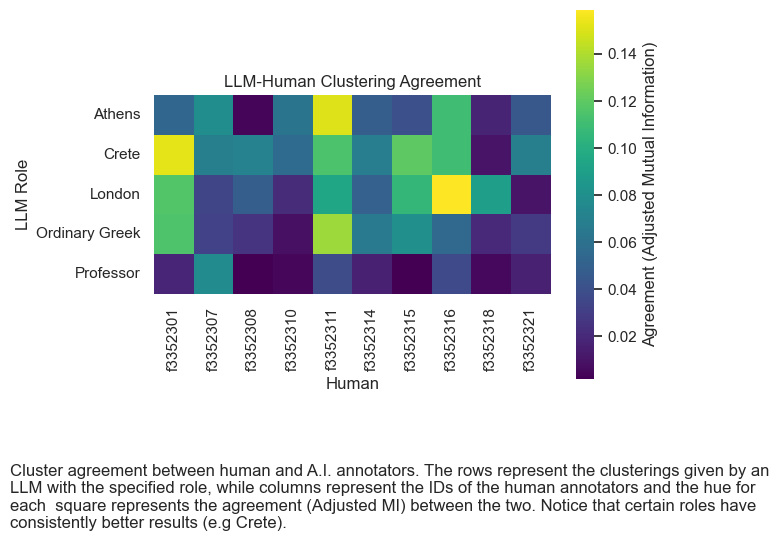

In [23]:
sns.heatmap(llm_gt_df, 
            cmap=sns.color_palette("viridis", as_cmap=True),
            square=True,
            cbar_kws={'label': "Agreement (Adjusted Mutual Information)"})

plt.title("LLM-Human Clustering Agreement")

caption_text = """Cluster agreement between human and A.I. annotators. The rows represent the clusterings given
by an LLM with the specified role, while columns represent the IDs of the human annotators and the hue for each 
square represents the agreement (Adjusted MI) between the two. Notice that certain roles have consistently better
results (e.g Crete).
"""
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.2, caption)

plt.show()

This time we change the colormap to be a simple gradient from blue to yellow instead of the bins we previously used. This will make it easier for the reader to quickly distinguish high from low values in our now much smaller dataset.

Indeed, we can at a glance observe the worst and best clusterings. The `Crete` prompt is visibly much lighter than the other clusterings, while the `Professor` prompt is almost completely dark.

We can verify this conclusion by averaging the AMI scores of each LLM clustering.

In [24]:
llm_gt_df.mean(axis=1).sort_values(ascending=False)

LLM Role
Crete             0.083831
London            0.072635
Athens            0.060830
Ordinary Greek    0.056407
Professor         0.021502
dtype: float64

## Conclusion

In this assignment we reviewed an annotation dataset and constructed an annotation "ground truth". We then engineered several prompts with which we obtained different clusterings from an LLM, and which we compared against the ground truth to obtain the optimal LLM clustering, thus successfully augmenting our annoatation dataset.

In [25]:
print(f"Notebook executed in {time()-start:.2f} seconds")

Notebook executed in 6.38 seconds
